# To do:
1. Make sure that previous commits are hidden
2. Ask Doug about how to make this properly open sourced.

In [115]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import geopandas as gpd

import shapely
from shapely.ops import unary_union
from shapely.geometry import Polygon
import alphashape

class ProvedArea:
    def __init__(self,realizations):

        #Pull in the Well Header CSV export and the Forecast Parameters CSV export from CC
        header_path = 'ComboCurve Header Example.csv'
        forecast_parameters_path = 'ComboCurve Forecast Parameter Example.csv'
        #header_path = r"C:\\Users\\Travis Salomaki\\Downloads\\EF_Wells.csv"
        #forecast_parameters_path = r"C:\\Users\\Travis Salomaki\\Downloads\\EF_Forecast_Parameters.csv"

        #Read in forecast_parameters file & perform a quick data cleaning
        forecast_parameters = pd.read_csv(forecast_parameters_path,usecols=['Well Name',
                                                                            'INPT ID',
                                                                            'EUR (MBBL, MMCF)',
                                                                            'EUR/FT (BBL/FT, MCF/FT)'])
        forecast_parameters.drop_duplicates(inplace = True)
        forecast_parameters.reset_index(inplace = True, drop = True)
        forecast_parameters['INPT ID'] = forecast_parameters['INPT ID'].astype(str)
        #forecast_parameters.drop(forecast_parameters['EUR/FT (BBL/FT, MCF/FT)'].isna(),inplace = True)

        #Read in the header file & format the INPT column
        headers = pd.read_csv(header_path,usecols=["INPT ID","Surface Latitude",'Surface Longitude','Perf Lateral Length'])
        headers['INPT ID'] = headers['INPT ID'].astype(str)

        #Merge forecast_parameters with headers to create a DataFrame containing both header info plus forecast parameter info
        df = pd.merge(left = forecast_parameters, right = headers, how = 'inner', on = 'INPT ID')

        #Create a GeoPandas DataFrame and define the active geometry as the Surface Lat Long points
        self.gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df['Surface Longitude'], df['Surface Latitude']))
        self.gdf.drop(self.gdf[self.gdf['EUR/FT (BBL/FT, MCF/FT)'].isna()].index,inplace=True)
        self.gdf.reset_index(inplace = True, drop = True)
        

        #Instantiates `self.radii_list` which contains the distance, in miles, of each of the radii to be created
        self.radii_list = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0])

        #Instantiates `self.mask_list` which will hold each of the created masks (i.e. which points belong to which radii)
        self.mask_list = []

        #Initiaiizes `self.radii_level` to be 1 or the 1st radii level
        self.radii_level = 1

        #Sets the number of realizations
        self.realizations = realizations

        #Instantiates the self.failed_realizations attribute
        self.failed_realizations = 0

        #Executes the self.driver() function
        self.driver()

    def calculate_p10_p90_ratio(self, x):
        """
        ARGS:
        x (array of floats)

        RETURNS: 
        float: p10/p90 ratio
        """
        p10 = np.quantile(x, 0.9)
        p90 = np.quantile(x, 0.1)
        return p10/p90
    
    def get_sample_size(self, ratio):
        """
        ARGS: 
        ratio (float): p10/p90 ratio
        
        RETURNS: 
        int: the minimum sample size required to yield a statistically 
             accurate distribution of >90% as defined by SPEE Monograph 3
        """
        ratio_ranges = {
            (0, 3): 15,
            (3, 4): 35,
            (4, 5): 60,
            (5, 6): 75,
            (6, 8): 100,
            (8, 10): 130,
            (10, 15): 170,
            (15, float('inf')): 200
        }

        for range_limits, sample_size in ratio_ranges.items():
            if range_limits[0] <= ratio < range_limits[1]:
                return sample_size

        return 200 
    
    def generate_anchors(self):
        """
        The function uses the calculated p10/p90 ratio of EUR/FT (BBL/FT, MCF/FT) values 
        to determine the required sample size using the `get_sample_size` method. It then 
        selects anchor wells by randomly sampling the data and storing their indices in `self.anchors_idx`.

        RETURNS: 
        None: The function modifes the `self.anchors_idx` attribute to store the indices of the
              randomly selected anchor points.
        
        """
        p10_p90_ratio = self.calculate_p10_p90_ratio(self.gdf['EUR/FT (BBL/FT, MCF/FT)'])
        sample_size = self.get_sample_size(p10_p90_ratio)
        self.anchors_idx = np.random.choice(self.gdf.index,sample_size, replace = False)
        return None
    
    def generate_radii(self, radius):
        """
        The function generates a buffer object surrounding all the analog points. 
        To convert the given geometry units from lat/long degrees into miles, 
        it divides the provided radius by 69.

        ARGS:
        radius (float): The length of the buffer radius in miles.

        RETURNS:
        array of Polygons: Buffer object representing polygons around points.
        """
        return self.gdf.geometry.buffer(radius / 69)
    
    def generate_boundary(self, radii):
        """
        Generate a merged multipolygon of overlapping anchor buffers.

        ARGS:
        radii (array of Polygons): Buffer object representing arrays of Polygons around well locations.

        RETURNS:
        MultiPolygon: Merged multipolygon of all overlapping anchor buffers.

        The function indexes the buffer object to access only the anchor well locations, 
        then uses the `unary_union` function to merge these anchor buffers. 
        Finally, it wraps the result in a GeoSeries.
        """
        return gpd.GeoSeries(unary_union(radii[self.anchors_idx]))

    def generate_mask(self, boundary, radii_level):
        """
        Generate a mask identifying wells in a specific concentric ring layer.

        ARGS:
        boundary (MultiPolygon): The boundary generated by the `generate_boundary` function.
        radii_level (int): Corresponds to the concentric ring layer level.

        RETURNS:
        Boolean Array: Indicates wells in the specified concentric ring layer 
                    that are not anchors and not in the previous ring layer(s).

        The function checks the specified `radii_level` to determine the concentric ring layer.
        If radii_level is 1, it returns a mask for wells within the first ring layer 
        that are not anchors.
        If radii_level is 2, it returns a mask for wells within the second ring layer 
        that are not anchors and not in the previous ring layer(s).
        For radii_level greater than 2, it generates a mask for wells in subsequent ring layers 
        using an aggregation function `aggregate_ands`.
        """
        if radii_level == 1:
            return (self.gdf.geometry.within(boundary[0]) & pd.Series(~self.gdf.index.isin(self.anchors_idx)))
        elif radii_level == 2:
            return (self.gdf.geometry.within(boundary[0]) & pd.Series(~self.gdf.index.isin(self.anchors_idx))) & ~self.mask_list[0]
        elif radii_level > 2:
            return (self.gdf.geometry.within(boundary[0]) & pd.Series(~self.gdf.index.isin(self.anchors_idx))) & self.aggregate_ands(self.mask_list)
        else:
            pass

    def aggregate_ands(self, masks):    
        """
        Aggregates boolean masks to identify wells used by other radii layers.

        ARGS:
        masks (list): List of boolean masks representing different radii layers.

        RETURNS:
        boolean array: Aggregated mask indicating wells already used by other radii layers.

        The function instantiates 'aggregated_masks' as the set of wells NOT in r1 nor r2.
        If 'masks' contains more than two items, it iterates through the remainder and redefines 'aggregated_masks'
        as everything NOT in the remaining radii layers.
        """
        aggregated_masks = ~masks[0] & ~masks[1]
        if len(masks) > 2:
            for mask in masks[2:]:
                aggregated_masks &= ~mask
        return aggregated_masks
    
    def update_radii_list(self, radii_level):
        """
        Increase the distances of the radii from the specified radii level to the end by 5%.

        ARGS:
        radii_level (int): The index indicating the starting radii level to be updated.

        RETURNS:
        None: Modifies the radii list in place.

        The function takes a radii level index and multiplies the lengths of radii starting 
        from the specified level to the end by 1.05, effectively increasing their lengths by 5%.
        """
        self.radii_list[radii_level:] = self.radii_list[radii_level:] * 1.05
        return None

    def iterate_masks(self):
        """
        Generate masks based on radii levels and append them to the mask list.

        The function generates masks for different radii levels within a defined boundary. 
        If a generated mask contains less than 50 points, it increases the radius and tries again. 
        After attempting to increase the radius 5 times or reaching more than 50 points in the mask, 
        it appends the created mask to the mask_list.

        If the radii distance cannot be increased further, the loop terminates.

        RETURNS:
        None: Modifies the mask_list in place.
        """
        for _ in range(5):

            # Generate an initial mask attempt
            mask = self.generate_mask(
                self.generate_boundary(self.generate_radii(self.radii_list[self.radii_level-1])),
                self.radii_level
                )

            update_count = 0
            while mask.sum() <= 50:
                if update_count == 5:
                    return  # Exit the function if radii cannot be increased further
                self.update_radii_list(self.radii_level - 1)
                update_count += 1

                mask = self.generate_mask(
                    self.generate_boundary(self.generate_radii(self.radii_list[self.radii_level - 1])),
                    self.radii_level
                )

            self.mask_list.append(mask)

            # Increment the radii_level parameter
            self.radii_level += 1

    def compare_masks(self):
        """

        This function iterates through the list of radii from smallest to largest. 
        It stops when either the mean EUR/ft value for a given radii level falls below 
        90% of the Analog Well Set mean or when it reaches the last radii group.

        RETURNS:
        int: The radii level considered 'proved'.
        """
        proved_radii = 0
        for idx,mask in enumerate(self.mask_list):
            mask_mean = self.gdf[mask]['EUR/FT (BBL/FT, MCF/FT)'].mean()
            if mask_mean < (0.9 *self.analog_mean):
                proved_radii = idx-1
                break
            else:
                proved_radii = idx
        return proved_radii
     
    def generate_proved_areas(self):
        """
        Generates a list of coordinates pertaining to the proveda area(s) of the reservoir. 

        Basically, we take the 'proved' radii level and generate buffer circles around our anchor wells.
        We then merge those buffer circles into a single multi-polygon and check what points exist within it. 
        Lastly, we use a concave hull to outline the analog wells within the polygon and store it in
        self.proved_areas. 

        Note, we're effectively appending the proved_areas list with the coordinates of the polygon(s) that define
        the proven area. 

        RETURNS:
        None: Modifies self.proved_areas in place.
        """
        # Clear the list before generating proved areas to ensure a clean start
        self.proved_areas = []

        # Retrieve the polygons corresponding to the 'proved' radii level
        proved_radii_polygons = self.generate_boundary(self.generate_radii(self.radii_list[self.proved_radii]))[0].geoms
        
        # Generate alpha shapes or concave hulls for wells within each polygon and store them in self.proved_areas
        for polygon in proved_radii_polygons:
            wells_within_polygon = self.gdf[self.gdf.geometry.within(polygon)]
            concave_hull = alphashape.alphashape(wells_within_polygon, 15)
            if concave_hull.geom_type == 'Polygon':
                self.proved_areas.append(tuple(concave_hull.exterior.coords))
            elif concave_hull.geom_type == 'MultiPolygon':
                for polygon in concave_hull.geoms:
                    self.proved_areas.append(tuple(polygon.exterior.coords))

        return None

    def generate_realization(self):
        """
        This method calculates the P10/P90 ratio of 'EUR/FT (BBL/FT, MCF/FT)' values 
        in the input data. If the ratio is less than 10, it attempts to generate anchor 
        points. If successful, it proceeds to check if the mean value of anchor points is 
        at least 90% of the mean value of analog wells. If it meets this condition, it 
        iterates through the masks, defines the 'proved_radii' level, generates the proved 
        areas, and stores them as realizations.

        RETURNS:
        None: Modifies 'self.proved_area_realizations' and other attributes in place based 
            on the generated proved areas.
        """
        if self.calculate_p10_p90_ratio(self.gdf["EUR/FT (BBL/FT, MCF/FT)"]) < 10:
    
            #Generate Anchor Points
            try:
                self.generate_anchors()
            except ValueError:
                print("Unable to generate anchor points. Input wellset population count is less than the calculated sample size.")
            
            self.analog_mean = np.mean(self.gdf["EUR/FT (BBL/FT, MCF/FT)"])
            self.anchor_mean = np.mean(self.gdf.loc[self.anchors_idx]["EUR/FT (BBL/FT, MCF/FT)"])
            
            if self.anchor_mean >= 0.9 * self.analog_mean: #Check if the anchor points mean value is greater than 0.9*mean(analog wells)
                self.iterate_masks() #Add all the masks to the mask_list
                self.proved_radii = self.compare_masks() #Define the proved_radii level
                try:
                    self.generate_proved_areas()
                except AttributeError:
                    pass

                self.proved_area_realizations[self.realization_count] = self.proved_areas
                return None
            else:
                #print('Anchor point mean EUR/FT is too low. Try re-intializing your Anchor points.')
                #print('Anchor sample is not representative of analog distribution.')
                self.failed_realizations += 1
                return None
        else:
            print(f'Analog Wellset P10/P90 Ratio: {self.calculate_p10_p90_ratio(self.gdf["EUR/FT (BBL/FT, MCF/FT)"])}')
            print('P10/P90 ratio of analog wellset is greater than 10. Please upload a more homogenous wellset.')
            return
        
    def aggregate_realizations(self):
        """
        Aggregates individual realization polygons to generate a GeoDataFrame 
        with counts of overlapping features in the combined polygons.

        This method takes the `self.proved_area_realizations`, converts each 
        realization represented as a list of coordinates into a `Polygon`, and 
        aggregates them into a single GeoDataFrame (`all`). It then employs a 
        nested function (`count_overlapping_features`) to determine overlapping 
        features within the combined polygons. The resulting GeoDataFrame 
        (`self.stacked_realization`) contains the count of overlapping features 
        for each segment of the combined polygons, sorted in descending order.

        Note:
        - The function `count_overlapping_features` is sourced from a StackExchange 
        user (@ni1o1) and is responsible for splitting the polygons and counting 
        overlapping features.

        RETURNS:
        None: Modifies the `self.stacked_realization` attribute in place.
        """

        realization_list = []
        for realization in [x for x in self.proved_area_realizations if x is not None]:
            for coords in realization:
                realization_list.append(Polygon(coords))
        all = gpd.GeoDataFrame(geometry = realization_list)
        
        def count_overlapping_features(gdf):

            #generating all of the split pieces
            bounds = gdf.geometry.exterior.unary_union
            new_polys = list(shapely.ops.polygonize(bounds))
            new_gdf = gpd.GeoDataFrame(geometry=new_polys)
            new_gdf['id'] = range(len(new_gdf))

            #count overlapping by sjoin between pieces centroid and the input gdf 
            new_gdf_centroid = new_gdf.copy()
            new_gdf_centroid['geometry'] = new_gdf.centroid
            overlapcount = gpd.sjoin(new_gdf_centroid,gdf)
            overlapcount = overlapcount.groupby(['id'])['index_right'].count().rename('count').reset_index()
            out_gdf = pd.merge(new_gdf,overlapcount)
            return out_gdf

        self.stacked_realization = count_overlapping_features(all)
        self.stacked_realization = self.stacked_realization.sort_values('count',ascending = False).reset_index(drop = True)
        return None

    def driver(self):
        self.proved_area_realizations = [None] * self.realizations
        self.realization_count = 0

        print("Generating realizations...")
        print("Realization Number: ",end = '')

        if self.realizations > 1:
            for _ in range(self.realizations):
                print(f'{self.realization_count + 1}',end = ', ')
                self.generate_realization()
                self.radii_list = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0])
                self.mask_list = []
                self.radii_level = 1
                self.realization_count += 1
        elif self.realizations == 1:
            print(1)
            self.generate_realization()
        else:
            pass

        #Stacks all the realizations and calculates the polygon overlaps
        self.aggregate_realizations()

        if self.failed_realizations > 0:
            print(f'\n\n{self.failed_realizations}/{self.realizations} realizations were not used as the mean EUR/FT of the anchor points did not exceed 90% of the analog set mean.')
        else:
            print('\nAll realizations completed successfully.')
            print(f'Proved Radii Distance: {self.radii_list[self.proved_radii]} miles')
        return None
    
    def plot_comparisons(self):
        """
        NOTE: This function only works if you run a single realization.
        """

        if len(self.proved_area_realizations) <= 1:
            avgs = []
            counts = []

            for i in self.mask_list:
                counts.append(len(self.gdf[i]))
                avgs.append(self.gdf[i]['EUR/FT (BBL/FT, MCF/FT)'].mean())

            analog_mean = self.gdf['EUR/FT (BBL/FT, MCF/FT)'].mean()
            anchor_mean = self.gdf.loc[self.anchors_idx]['EUR/FT (BBL/FT, MCF/FT)'].mean()

            avgs.insert(0,analog_mean)
            counts.insert(0,len(self.gdf['EUR/FT (BBL/FT, MCF/FT)']))

            avgs.insert(1,anchor_mean)
            counts.insert(1,len(self.anchors_idx))

            fig,ax = plt.subplots(1,2,figsize = [15,5])
            xticks = ['Analog Wells','Anchor Wells'] + [ 'r' + str(i) for i in range(1,len(self.mask_list)+1)]
            ax[0].set_xticks(np.arange(len(self.mask_list)+2),labels = xticks,rotation = 45)
            ax[1].set_xticks(np.arange(len(self.mask_list)+2),labels = xticks,rotation = 45)
            ax[0].set_ylabel('EUR/FT')
            ax[1].set_ylabel('Wells')

            ax[0].plot(avgs,label = 'EUR/FT Avg')
            ax[1].plot(counts,label = 'Well Count',color = 'green')
            ax[0].hlines(xmin = 0,xmax=len(self.mask_list)+1, y = 0.9*analog_mean,linestyles='dashed',color = 'black')

            ax[0].scatter(np.arange(len(self.mask_list)+2),avgs,color ='black')
            ax[1].scatter(np.arange(len(self.mask_list)+2),counts,color = 'black')

            ax[0].legend()
            ax[1].legend()

            ax[0].grid()
            ax[1].grid()
        else:
            print("Too many realizations. Please instantiate a new ProvedArea object with the realizations parameter set to '1'")
        return None

    def plot_proved_areas(self):
        """
        NOTE: This function only works if you run a single realization.
        """
        if self.realizations == 1:   
            _, ax = plt.subplots(figsize = [13,15])
            self.generate_boundary(self.generate_radii(self.radii_list[self.proved_radii])).plot(ax=ax,alpha = 1,color = 'lightblue')
            for i in self.proved_area_realizations[-1]:
                gpd.GeoSeries(Polygon(i)).plot(ax=ax,alpha = 0.8,color = 'darkblue')
            self.gdf.plot(ax=ax,c= 'black',label = 'Analog Wells')
            self.gdf.loc[self.anchors_idx].plot(ax=ax,c='red',label= 'Anchor Wells',alpha = 0.8)

            legend_elements = [Line2D([0],[0],marker = 'o',color = 'w',markerfacecolor='black',label = 'Analog Wells',markersize= 8),
                            Line2D([0],[0],marker = 'o',color = 'w',markerfacecolor='red',label = 'Anchor Wells',markersize= 8),
                            Patch(facecolor='lightblue',edgecolor= 'w',label='Proved Radii'),
                            Patch(facecolor='blue',edgecolor='w',label= 'Proved Area')
                            ]
            ax.legend(handles = legend_elements)
            ax.grid()
            ax.set_xlabel("Longitude")
            ax.set_ylabel('Latitude')
        else:
            print("Too many realizations. Please instantiate a new ProvedArea object with the realizations parameter set to '1'")
        return None
    
    def plot_wells(self):
        """
        NOTE: This function only works if you run a single realization. 
        """

        if self.realizations == 1:
            fig,ax = plt.subplots(figsize=[12,12])
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            self.gdf.plot(label = 'Analog Wells',ax =ax,color = 'black')

            #Radiis 
            for idx,i in enumerate(reversed(self.radii_list[0:self.proved_radii+1])):
                self.generate_boundary(self.generate_radii(i)).plot(ax=ax,alpha = np.linspace(0.2,1,self.proved_radii+1)[idx],color = 'grey')

            #Points in radii
            for idx,x in enumerate(self.mask_list):
                self.gdf[self.mask_list[idx]].plot(label = f'r{idx+1} wells',ax=ax)

            ax.legend()
        else:
            print("Too many realizations. Please instantiate a new ProvedArea object with the realizations parameter set to '1'")
        return None
    
    def plot_aggregate_realization(self,p_series = 0):
        quantile = np.quantile(self.stacked_realization['count'].values,1-p_series)
        stacked_realization_subset = self.stacked_realization.loc[self.stacked_realization['count'] >= quantile]

        stacked_realization_subset_boundary = gpd.GeoDataFrame(geometry=[stacked_realization_subset.geometry.unary_union.boundary])

        _, ax = plt.subplots(figsize = [10,10])
        overlaps = stacked_realization_subset.plot(ax=ax,column = 'count',legend = True,cmap = 'plasma')
        boundary = stacked_realization_subset_boundary.plot(ax=ax, color = 'black')
        self.gdf.plot(ax=ax,color = 'black',label = 'Analog Wells',markersize = 3)
        ax.set_title(f'Aggregate Realization (P{int(p_series*100)})')
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend()

    def export_shapefiles(self, p_series = 0):

        folder_name = input("What would you like to name the ShapeFile?: ")
        folder_path = os.getcwd()+'\\'+folder_name
        try:
            os.mkdir(folder_path)
        except FileExistsError:
            pass

        quantile = np.quantile(g.stacked_realization['count'].values,1-p_series)
        stacked_realization_subset = self.stacked_realization.loc[self.stacked_realization['count'] >= quantile]

        shapefile_gdf = gpd.GeoDataFrame(geometry=[stacked_realization_subset.geometry.unary_union],crs = 'EPSG:4326')
        shapefile_gdf.to_file(folder_path)
        os.remove(folder_path + '\\' + folder_name +'.cpg')
        shutil.make_archive(folder_name, 'zip', folder_path)
        return None 


In [116]:
single_realization = ProvedArea(1)

Generating realizations...
Realization Number: 1

All realizations completed successfully.
Proved Radii Distance: 2.0 miles


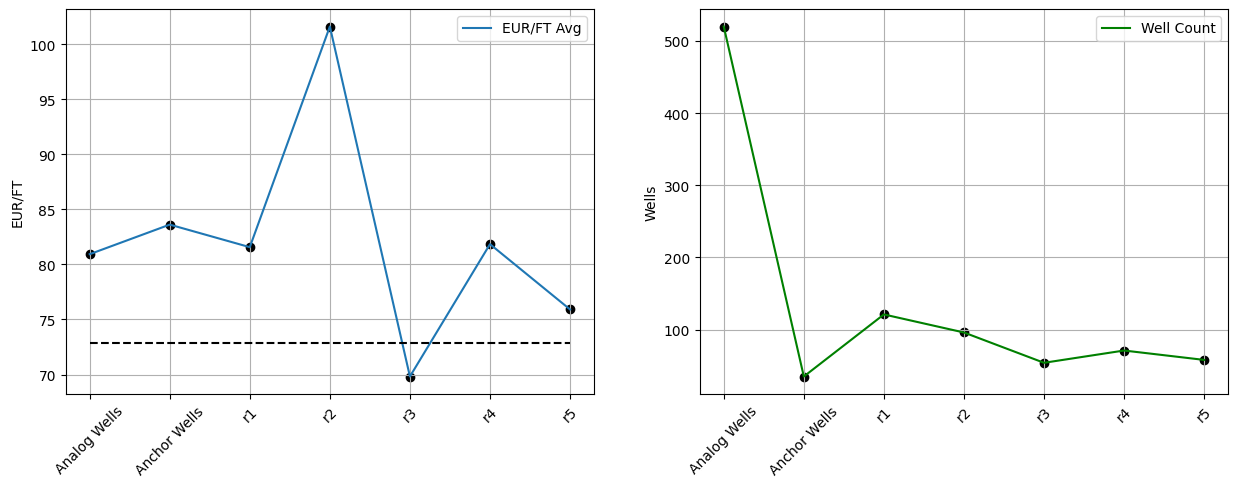

In [117]:
single_realization.plot_comparisons()

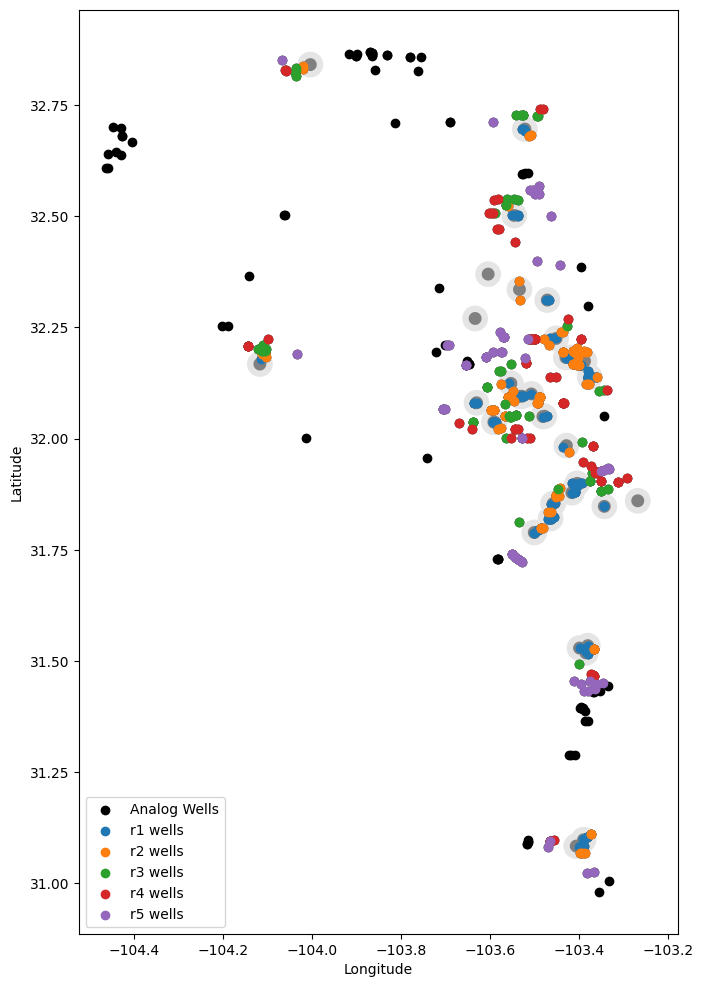

In [118]:
single_realization.plot_wells()

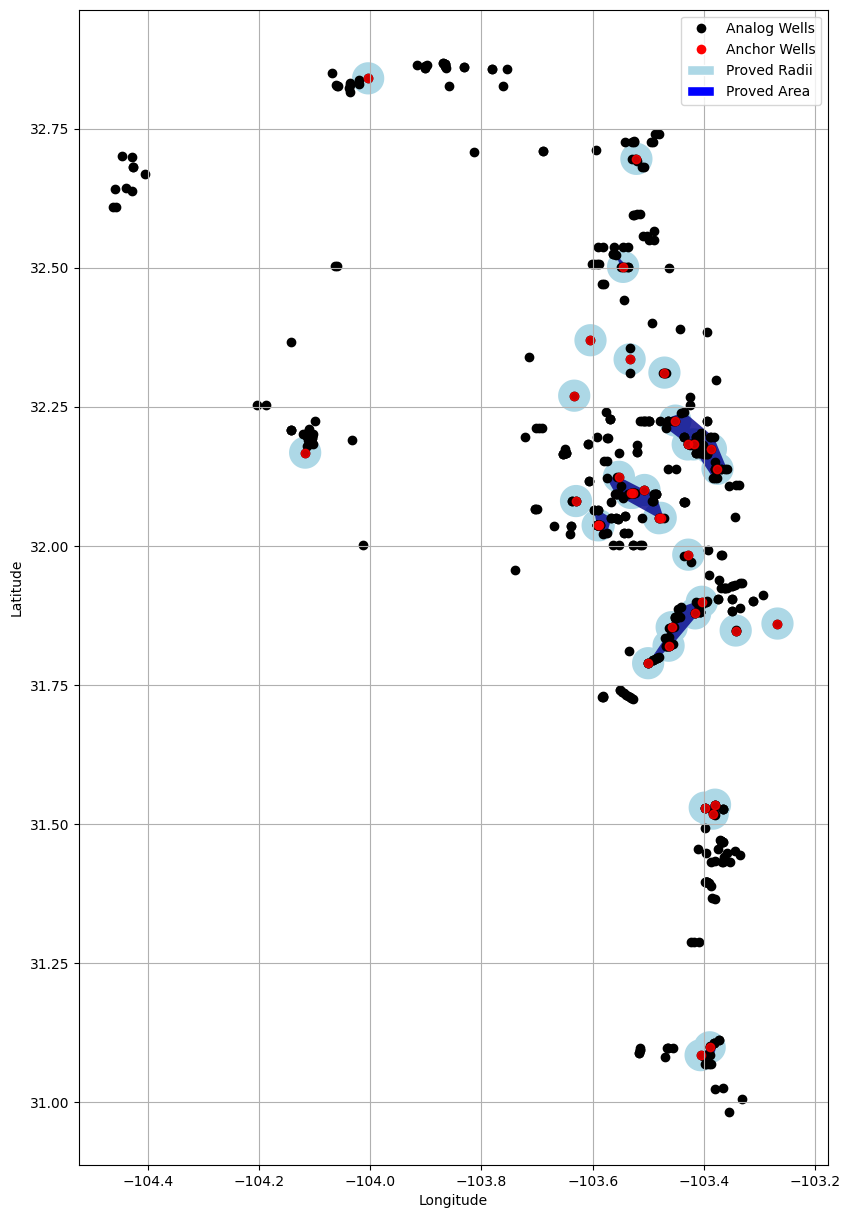

In [119]:
single_realization.plot_proved_areas()

In [120]:
multiple_realizations = ProvedArea(1000)

Generating realizations...
Realization Number: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 

28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 

226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 

# <b>ProvedArea.py</b>
##### "An automated Python implementation of SPEE Monograph 3's Expanding Concentric Radii Method for defining the statistically proved area of a resource play"
Travis Salomaki, 2023<br>
ComboCurve, Inc.

-----
### <b>Motivation</b>
The program below presents a Python implementation of SPEE Monograph 3's Expanding Concentric Radii method and introduces a novel* method of generating a unique probabilistic solution through the use of geospatial Monte Carlo sampling.

Since its initial release in 2010, the recommendations introduced by the Society of Petroleum Evaluation Engineer's (SPEE) Monograph 3 have been largely integrated into the key workflows and operating principles of modern exploration and production companies. In chapter three of the monograph, the authors present two methods of determining the statistically proved area of a resource play. For those unfamiliar with the terminology, a <b>resource play</b> can simply be thought of as a regional extent of hydrocarbons exhibiting "low risk and repeatable results," while the term <b>proved</b>, in the context of Oil and Gas reserve evaluations, refers to the "quantity of [hydrocarbons] that a company reasonably expects to extract from a given formation." Specifically, "proven reserves are classified as having a 90% or greater likelihood of being present and economically viable for extraction in current conditions."  NEED TO CITE INVESTOPEDIA (https://www.investopedia.com/terms/p/proven-reserves.asp)

The Expanding Concentric Radii Method offers a straightforward means of determining the statistically proved area of a resource play. At a high level, the process involves randomly selecting a group of "anchor" wells within a given population of "analog" wells, generating concentric circles around the anchor wells, and comparing the statistical characteristics of the wells that fall into the concentric circles against those of the analog population until you reach a radial distance in which the associated well charactertics are no longer representative of the analog population. 

At the time of Monograph 3's publication, implementing the Expanding Concentric Radii method in practice would have proven to be largely inconvenient and time consuming due to the limitations of GIS mapping platforms, produciton data access, and manually intensive DCA forecasts. Additionally, given that the anchor wells are randomly selected, the methodology results in a non-unique output that can vary widely from realization to realization. Given the advancements in computational efficiency, the advent of open-source geospatial Python libraries, and the wide-spread adoption of modern auto-forecasting platforms such as ComboCurve, ProvedArea.py provides operators, mineral shops, investment banks, and industry peers alike with a practical means of implementing the Expanding Concentric Radii Method and offers the added benefit of unique probabilistic outputs. 

---

### <b>Assumptions, Inputs, and Requirements</b>

##### Assumptions
* The well set comprises of a single 'contiguous' drilling area.
* The target resource play is considered to be in the "statistical phase" of maturity. 
<br>

##### Inputs

All program inputs are taken directly from easily accesible ComboCurve exports. 
* ComboCurve Well Header Export (.csv)
* ComboCurve Forecast Parameter Export (.csv)

To access the Well Header Export, navigate to the Project Wells tab of your ComboCurve project and click the download icon located in the top right corner of the well header table. 
<br>To access the Forecast Parameter Export, open a ComboCurve forecast set, click "Forecast Options," and then click "Export Forecast Parameters (CSV)."

##### Requirements
* All wells in the forecast set have a forecast generated for the oil phase and have a perforated lateral length (PLL) populated in the well header table. 
* All wells need both a surface lattitude and a surface lattitude field populated in the well header table. 


---

### Dependencies

Before using the Jupyter Notebook, please make sure you have the following Python libaries installed:
1. pandas
1. numpy
1. matplotlib
1. geopandas
1. shapely
1. alphashape



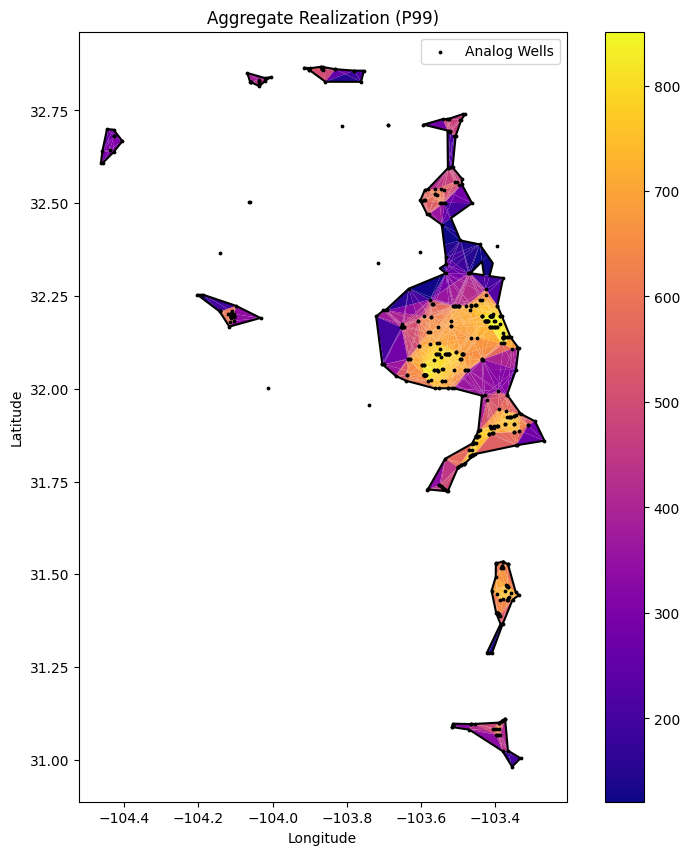

In [123]:
multiple_realizations.plot_aggregate_realization(0.99)